# Bulk RNA-seq Analysis with Single-Cell Integration - Reproducibility Assessment

## Overview
This notebook performs comprehensive bulk RNA-seq analysis on integrated bulk and single-cell data to assess reproducibility across samples and genotypes. It includes quality control, differential expression analysis, batch correction, and sample-specific marker identification.

## Objectives
1. Load and filter integrated bulk + single-cell expression data
2. Perform quality control and library size assessment  
3. Run DESeq2 differential expression analysis with batch correction
4. Create PCA plots and heatmaps for sample clustering
5. Calculate sample distances for reproducibility metrics
6. Identify sample-specific marker genes
7. Generate volcano plots for differential expression

## Expected Outputs
- Quality-filtered expression and metadata files
- Normalized and batch-corrected expression matrices
- PCA plots colored by sample and genotype
- Sample distance matrices and heatmaps
- Differential expression results for each sample comparison
- Volcano plots for significant genes

## Input Requirements
- Integrated expression matrix from bulk + single-cell data
- Sample metadata with genotype, sample, and replicate information
- Sufficient library sizes for reliable analysis

## Analysis Pipeline
1. **Data Loading & QC**: Load data and assess library sizes
2. **Filtering**: Remove low-count samples and genes
3. **DESeq2 Setup**: Create DESeqDataSet with appropriate design
4. **Normalization**: VST transformation and batch correction
5. **Visualization**: PCA, clustering, and quality plots
6. **Distance Analysis**: Sample similarity assessment
7. **Differential Expression**: Sample-specific marker identification
8. **Results Export**: Save all outputs and generate final plots

## Configuration and Parameters

In [ ]:
# Centralized Configuration
suppressWarnings(suppressMessages({
    
    # Set reproducibility
    set.seed(42)
    
    # Analysis parameters
    MIN_COUNT_THRESHOLD <- 600000    # Minimum library size threshold
    MIN_GENE_COUNT <- 10            # Minimum gene count threshold
    P_VALUE_CUTOFF <- 0.05          # P-value cutoff for significance
    LFC_THRESHOLD <- 1              # Log fold change threshold
    TOP_GENES_HEATMAP <- 20         # Number of top genes for heatmap
    
    # File paths
    BASE_DIR <- getwd()
    DATA_DIR <- file.path(BASE_DIR, "bulk")
    OUTPUT_DIR <- file.path(BASE_DIR, "stability_plots")
    FIGURES_DIR <- file.path(BASE_DIR, "figures")
    
    # Input files
    EXPRESSION_FILE <- file.path(DATA_DIR, "reproducibility_genotypes_wSC.tsv")
    METADATA_FILE <- file.path(DATA_DIR, "reproducibility_genotypes_wSC_meta.tsv")
    
    # Output files
    VSD_ORIG_FILE <- file.path(DATA_DIR, "reproducibility_genotypes_deseq2_vsd_wSC.tsv")
    VSD_CORR_FILE <- file.path(DATA_DIR, "reproducibility_genotypes_deseq2_vsd_corr_wSC.tsv")
    DISTANCES_FILE <- file.path(DATA_DIR, "reproducibility_genotypes_deseq2_limma_corr_pca_distances_wSC.tsv")
    
    # Create output directories
    dir.create(OUTPUT_DIR, showWarnings = FALSE, recursive = TRUE)
    dir.create(FIGURES_DIR, showWarnings = FALSE, recursive = TRUE)
    
    # Plot settings
    options(repr.plot.width = 8, repr.plot.height = 8)
    
    cat("Configuration loaded successfully\n")
    cat("Base directory:", BASE_DIR, "\n")
    cat("Data directory:", DATA_DIR, "\n")
    cat("Output directory:", OUTPUT_DIR, "\n")
    cat("Minimum count threshold:", MIN_COUNT_THRESHOLD, "\n")
    cat("Minimum gene count:", MIN_GENE_COUNT, "\n")
    
}))

## Library Imports

In [ ]:
suppressWarnings(suppressMessages({
    
    # Core analysis libraries
    library(DESeq2)         # Differential expression analysis
    library(useful)         # Utility functions
    library(dplyr)          # Data manipulation
    library(limma)          # Batch correction
    
    # Visualization libraries
    library(ggplot2)        # Plotting
    library(EnhancedVolcano) # Volcano plots
    library(gridExtra)      # Plot arrangements
    library(pheatmap)       # Heatmaps
    library(RColorBrewer)   # Color palettes
    library(repr)           # Plot representation
    library(vsn)            # Variance stabilization
    
    # Annotation libraries
    library(biomaRt)        # Gene annotation
    
    cat("All libraries loaded successfully\n")
    cat("DESeq2 version:", as.character(packageVersion("DESeq2")), "\n")
    cat("ggplot2 version:", as.character(packageVersion("ggplot2")), "\n")
    cat("dplyr version:", as.character(packageVersion("dplyr")), "\n")
    
}))

Possible Ensembl SSL connectivity problems detected.
Please see the 'Connection Troubleshooting' section of the biomaRt vignette
vignette('accessing_ensembl', package = 'biomaRt')Error in curl::curl_fetch_memory(url, handle = handle) : 
  SSL certificate problem: certificate has expired




## Data Loading and Quality Control

In [ ]:
# Load and validate input data
load_and_validate_data <- function() {
    cat("Loading integrated bulk + single-cell data...\n")
    
    # Check file existence
    if (!file.exists(EXPRESSION_FILE)) {
        stop("Expression file not found: ", EXPRESSION_FILE)
    }
    if (!file.exists(METADATA_FILE)) {
        stop("Metadata file not found: ", METADATA_FILE)
    }
    
    # Load expression data
    data <- read.csv(EXPRESSION_FILE, sep="\t", header=TRUE, quote="", row.names=1)
    cat("Expression data loaded:", nrow(data), "genes x", ncol(data), "samples\n")
    
    # Load metadata
    meta <- read.csv(METADATA_FILE, sep="\t", header=TRUE, row.names=1, quote="")
    cat("Metadata loaded:", nrow(meta), "samples\n")
    
    # Validate data consistency
    common_samples <- intersect(colnames(data), rownames(meta))
    if (length(common_samples) != ncol(data)) {
        cat("Warning: Sample mismatch between expression and metadata\n")
        cat("Expression samples:", ncol(data), "Metadata samples:", nrow(meta), "Common:", length(common_samples), "\n")
        
        # Align data
        data <- data[, common_samples]
        meta <- meta[common_samples, ]
        cat("Data aligned to", length(common_samples), "common samples\n")
    }
    
    # Display data overview
    cat("\nData overview:\n")
    print(corner(data))
    cat("\nMetadata overview:\n")
    print(corner(meta))
    
    return(list(expression = data, metadata = meta))
}

# Load data
data_list <- load_and_validate_data()
data <- data_list$expression
meta <- data_list$metadata

cat("\nData loading completed successfully!\n")

,Reproducibility_SC102A1_1_4,Reproducibility_SC102A1_1_9,Reproducibility_SC102A1_3_7,Reproducibility_SC102A1_2_12,Reproducibility_SC102A1_3_8
,<int>,<int>,<int>,<int>,<int>
5S_rRNA,0,0,0,0,0
5_8S_rRNA,0,0,0,0,0
7SK,0,2,0,0,1
A1BG,3,0,8,6,2
A1BG-AS1,5,8,23,4,9


                              counts
Reproducibility_SC102A1_2_12  694620
Reproducibility_409B2_3_9     719328
Reproducibility_SC102A1_2_10  767191
Reproducibility_409B2_3_8     875568
Reproducibility_SC102A1_1_4  1039543
Reproducibility_409B2_1_9    1065170
Reproducibility_409B2_1_10   1101327
Reproducibility_409B2_2_11   1126441
Reproducibility_409B2_3_10   1134944
Reproducibility_SC102A1_3_3  1155501
Reproducibility_SC102A1_2_6  1196901
Reproducibility_SC102A1_2_9  1206742
Reproducibility_409B2_1_11   1257595
Reproducibility_SC102A1_2_8  1348340
Reproducibility_409B2_1_12   1369472
Reproducibility_SC102A1_2_5  1473927
Reproducibility_SC102A1_1_10 1486711
Reproducibility_409B2_2_12   1508656
Reproducibility_SC102A1_3_10 1650598
Reproducibility_409B2_3_7    1652855


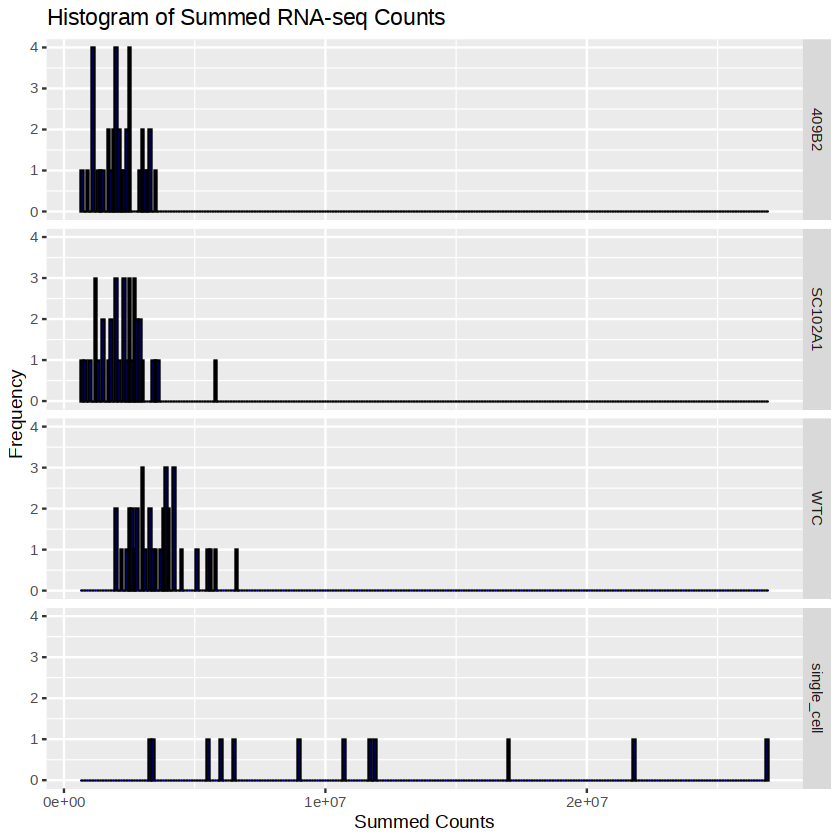

In [ ]:
# Load your dataset
# Replace 'your_dataset.csv' with the path to your RNA-seq counts file
# and make sure the column containing counts is correctly specified.

# Assuming the counts are in a column named 'counts'
# Adjust 'counts' to the actual column name in your dataset
counts <- colSums(data)
# Create a dataframe from the counts for easier manipulation and plotting
counts_df <- data.frame(counts = counts)

meta['counts'] <- colSums(data)

# Library size assessment and quality control
perform_library_qc <- function(expression_data, metadata) {
    cat("Performing library size quality control...\n")
    
    # Calculate library sizes (total counts per sample)
    library_sizes <- colSums(expression_data)
    metadata$counts <- library_sizes
    
    cat("Library size statistics:\n")
    cat("  Min:", min(library_sizes), "\n")
    cat("  Max:", max(library_sizes), "\n")
    cat("  Mean:", round(mean(library_sizes), 0), "\n")
    cat("  Median:", round(median(library_sizes), 0), "\n")
    
    # Create library size distribution plot
    p1 <- ggplot(metadata, aes(x = counts)) +
        geom_histogram(binwidth = 100000, fill = 'steelblue', color = 'black', alpha = 0.7) +
        ggtitle('Distribution of Library Sizes (Total Counts per Sample)') +
        xlab('Total Counts') +
        ylab('Number of Samples') +
        theme_minimal() +
        theme(plot.title = element_text(size = 14, hjust = 0.5))
    
    # Create genotype-specific distribution
    p2 <- ggplot(metadata, aes(x = counts, fill = genotype)) +
        geom_histogram(binwidth = 100000, alpha = 0.7, position = "identity") +
        ggtitle('Library Sizes by Genotype') +
        xlab('Total Counts') +
        ylab('Number of Samples') +
        facet_wrap(~genotype, scales = "free_y") +
        theme_minimal() +
        theme(plot.title = element_text(size = 14, hjust = 0.5),
              legend.position = "none")
    
    print(p1)
    print(p2)
    
    # Identify low-count samples
    low_count_samples <- which(library_sizes < MIN_COUNT_THRESHOLD)
    if (length(low_count_samples) > 0) {
        cat("\nSamples below threshold (", MIN_COUNT_THRESHOLD, "):\n")
        low_count_data <- data.frame(
            Sample = names(library_sizes)[low_count_samples],
            Counts = library_sizes[low_count_samples],
            Genotype = metadata[names(library_sizes)[low_count_samples], "genotype"]
        )
        print(low_count_data)
    } else {
        cat("\nAll samples pass library size threshold\n")
    }
    
    return(metadata)
}

# Perform QC analysis
meta <- perform_library_qc(data, meta)

cat("\nLibrary size assessment completed!\n")


In [ ]:
# Define the minimum count threshold
min_count_threshold <- 600000  # Replace with your desired threshold

# Filter samples and genes based on quality thresholds
filter_low_quality_data <- function(expression_data, metadata) {
    cat("Filtering low-quality samples and genes...\n")
    
    # Filter samples by library size
    high_quality_samples <- colSums(expression_data) >= min_count_threshold
    n_filtered_samples <- sum(!high_quality_samples)
    
    if (n_filtered_samples > 0) {
        cat("Filtering", n_filtered_samples, "samples with <", min_count_threshold, "total counts\n")
        filtered_samples <- names(high_quality_samples)[!high_quality_samples]
        cat("Filtered samples:", paste(filtered_samples, collapse = ", "), "\n")
    }
    
    # Apply sample filter
    filtered_data <- expression_data[, high_quality_samples]
    filtered_meta <- metadata[high_quality_samples, ]
    
    cat("After sample filtering:", nrow(filtered_data), "genes x", ncol(filtered_data), "samples\n")
    
    # Filter genes with very low expression
    gene_counts <- rowSums(filtered_data > 0)  # Number of samples with non-zero expression
    low_expr_genes <- gene_counts < 2  # Genes expressed in fewer than 2 samples
    
    if (sum(low_expr_genes) > 0) {
        cat("Removing", sum(low_expr_genes), "genes with expression in <2 samples\n")
        filtered_data <- filtered_data[!low_expr_genes, ]
    }
    
    cat("Final filtered data:", nrow(filtered_data), "genes x", ncol(filtered_data), "samples\n")
    
    # Validate genotype distribution after filtering
    cat("\nGenotype distribution after filtering:\n")
    print(table(filtered_meta$genotype))
    
    cat("\nSample distribution after filtering:\n")
    print(table(filtered_meta$sample))
    
    return(list(expression = filtered_data, metadata = filtered_meta))
}

# Apply filtering
filtered_data_list <- filter_low_quality_data(data, meta)
filtered_data <- filtered_data_list$expression
filtered_meta <- filtered_data_list$metadata

cat("\nData filtering completed!\n")


## DESeq2 Analysis Setup

In [ ]:
# Prepare DESeq2 analysis
setup_deseq2_analysis <- function(expression_data, metadata) {
    cat("Setting up DESeq2 analysis...\n")
    
    # Prepare column data for DESeq2
    deseq2.colData <- metadata
    deseq2.colData$sums <- colSums(expression_data)
    
    # Convert categorical variables to factors
    columns_to_factor <- c("sample", "repl", "genotype")
    for (col in columns_to_factor) {
        if (col %in% colnames(deseq2.colData)) {
            deseq2.colData[[col]] <- factor(deseq2.colData[[col]])
            cat("Converted", col, "to factor with", nlevels(deseq2.colData[[col]]), "levels\n")
        }
    }
    
    # Display column data summary
    cat("\nDESeq2 column data summary:\n")
    print(corner(deseq2.colData))
    
    # Ensure row names match
    rownames(deseq2.colData) <- colnames(expression_data)
    
    # Create DESeq2 dataset with appropriate design
    # Design accounts for both genotype and sample effects
    cat("\nCreating DESeqDataSet...\n")
    dds <- DESeqDataSetFromMatrix(
        countData = expression_data, 
        colData = deseq2.colData,
        design = ~ genotype + sample
    )
    
    cat("DESeqDataSet created successfully\n")
    cat("Design formula: ~ genotype + sample\n")
    cat("Samples:", ncol(dds), "\n")
    cat("Genes before filtering:", nrow(dds), "\n")
    
    return(list(dds = dds, colData = deseq2.colData))
}

# Setup DESeq2 analysis
deseq2_setup <- setup_deseq2_analysis(filtered_data, filtered_meta)
dds <- deseq2_setup$dds
deseq2.colData <- deseq2_setup$colData

cat("\nDESeq2 setup completed!\n")

In [ ]:
# Run DESeq2 differential expression analysis
run_deseq2_analysis <- function(dds_object) {
    cat("Running DESeq2 differential expression analysis...\n")
    
    # Filter low-count genes
    cat("Filtering genes with low counts...\n")
    keep <- rowSums(counts(dds_object)) >= MIN_GENE_COUNT
    n_filtered_genes <- sum(!keep)
    cat("Filtering", n_filtered_genes, "genes with <", MIN_GENE_COUNT, "total counts\n")
    
    dds_filtered <- dds_object[keep, ]
    cat("Genes after filtering:", nrow(dds_filtered), "\n")
    
    # Run DESeq2 analysis
    cat("Running DESeq2 estimation and testing...\n")
    dds_analyzed <- DESeq(dds_filtered)
    
    # Check convergence
    cat("Checking model convergence...\n")
    convergence_table <- table(mcols(dds_analyzed)$betaConv)
    print(convergence_table)
    
    if (any(names(convergence_table) == "FALSE")) {
        cat("Warning:", convergence_table["FALSE"], "genes did not converge\n")
    } else {
        cat("All genes converged successfully\n")
    }
    
    # Get basic results
    res <- results(dds_analyzed)
    res <- res[order(rownames(res)), ]
    
    cat("DESeq2 analysis completed\n")
    cat("Results summary:\n")
    print(summary(res))
    
    return(list(dds = dds_analyzed, results = res))
}

# Run DESeq2 analysis
deseq2_results <- run_deseq2_analysis(dds)
dds <- deseq2_results$dds
res <- deseq2_results$results

cat("\nDESeq2 analysis completed successfully!\n")

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



## Normalization and Batch Correction

In [ ]:
# Perform normalization and create transformed data
perform_normalization <- function(dds_object) {
    cat("Performing data normalization and transformation...\n")
    
    # Extract normalized counts
    normalized_counts <- counts(dds_object, normalized = TRUE)
    cat("Normalized counts extracted:", nrow(normalized_counts), "genes x", ncol(normalized_counts), "samples\n")
    
    # Variance stabilizing transformation
    cat("Applying variance stabilizing transformation (VST)...\n")
    vsd <- vst(dds_object, blind = FALSE)
    vsd_original <- vsd  # Keep original for comparison
    
    cat("VST transformation completed\n")
    
    # Save original VST data
    cat("Saving original VST data...\n")
    write.table(assay(vsd_original), VSD_ORIG_FILE, sep = "\t", quote = FALSE)
    cat("Original VST data saved to:", VSD_ORIG_FILE, "\n")
    
    return(list(
        normalized_counts = normalized_counts,
        vsd = vsd,
        vsd_original = vsd_original
    ))
}

# Perform normalization
norm_results <- perform_normalization(dds)
normalized_counts <- norm_results$normalized_counts
vsd <- norm_results$vsd
vsd_orig <- norm_results$vsd_original

cat("\nNormalization completed successfully!\n")

In [ ]:
# Perform batch correction using limma
perform_batch_correction <- function(vsd_object) {
    cat("Performing batch correction...\n")
    
    # Extract assay data
    mat <- assay(vsd_object)
    
    # Create design matrix for sample effects
    mm <- model.matrix(~ sample, colData(vsd_object))
    cat("Design matrix created with", ncol(mm), "columns\n")
    
    # Remove batch effects (genotype as batch, sample as design)
    cat("Removing genotype batch effects while preserving sample effects...\n")
    mat_corrected <- limma::removeBatchEffect(mat, batch = vsd_object$genotype, design = mm)
    
    # Update the VST object with corrected data
    assay(vsd_object) <- mat_corrected
    
    # Save batch-corrected data
    cat("Saving batch-corrected VST data...\n")
    write.table(assay(vsd_object), VSD_CORR_FILE, sep = "\t", quote = FALSE)
    cat("Batch-corrected VST data saved to:", VSD_CORR_FILE, "\n")
    
    return(vsd_object)
}

# Apply batch correction
vsd <- perform_batch_correction(vsd)

cat("\nBatch correction completed successfully!\n")


## Principal Component Analysis and Visualization

In [ ]:
# Comprehensive PCA analysis and plotting
perform_pca_analysis <- function(vsd_original, vsd_corrected) {
    cat("Performing comprehensive PCA analysis...\n")
    
    # Create PCA plots for original data
    cat("Creating PCA plots for original (non-batch-corrected) data...\n")
    
    # Original data - by sample
    pca_orig_sample <- plotPCA(vsd_original, intgroup = c('sample')) +
        scale_color_brewer(palette = "Paired") +
        ggtitle("PCA - Original Data (by Sample)") +
        theme_minimal() +
        theme(plot.title = element_text(hjust = 0.5))
    
    # Original data - by genotype  
    pca_orig_genotype <- plotPCA(vsd_original, intgroup = c('genotype')) +
        scale_color_brewer(palette = "Dark2") +
        ggtitle("PCA - Original Data (by Genotype)") +
        theme_minimal() +
        theme(plot.title = element_text(hjust = 0.5))
    
    # Create PCA plots for batch-corrected data
    cat("Creating PCA plots for batch-corrected data...\n")
    
    # Batch-corrected data - by sample
    pca_corr_sample <- plotPCA(vsd_corrected, intgroup = c('sample')) +
        scale_color_brewer(palette = "Paired") +
        ggtitle("PCA - Batch Corrected Data (by Sample)") +
        theme_minimal() +
        theme(plot.title = element_text(hjust = 0.5))
    
    # Batch-corrected data - by genotype
    pca_corr_genotype <- plotPCA(vsd_corrected, intgroup = c('genotype')) +
        scale_color_brewer(palette = "Dark2") +
        ggtitle("PCA - Batch Corrected Data (by Genotype)") +
        theme_minimal() +
        theme(plot.title = element_text(hjust = 0.5))
    
    # Batch-corrected data - by replicate
    pca_corr_repl <- plotPCA(vsd_corrected, intgroup = c('repl')) +
        scale_color_brewer(palette = "Set3") +
        ggtitle("PCA - Batch Corrected Data (by Replicate)") +
        theme_minimal() +
        theme(plot.title = element_text(hjust = 0.5))
    
    # Display plots
    print(pca_orig_sample)
    print(pca_orig_genotype)
    print(pca_corr_sample)
    print(pca_corr_genotype)
    print(pca_corr_repl)
    
    # Save plots
    cat("Saving PCA plots...\n")
    ggsave(file.path(FIGURES_DIR, "reproducibility_PCA_orig_sample.pdf"), 
           plot = pca_orig_sample, width = 8, height = 6)
    ggsave(file.path(FIGURES_DIR, "reproducibility_PCA_orig_genotype.pdf"), 
           plot = pca_orig_genotype, width = 8, height = 6)
    ggsave(file.path(FIGURES_DIR, "reproducibility_PCA_bc_sample.pdf"), 
           plot = pca_corr_sample, width = 8, height = 6)
    ggsave(file.path(FIGURES_DIR, "reproducibility_PCA_bc_genotype.pdf"), 
           plot = pca_corr_genotype, width = 8, height = 6)
    ggsave(file.path(FIGURES_DIR, "reproducibility_PCA_bc_replicate.pdf"), 
           plot = pca_corr_repl, width = 8, height = 6)
    
    cat("PCA analysis completed and plots saved\n")
    
    return(list(
        orig_sample = pca_orig_sample,
        orig_genotype = pca_orig_genotype,
        corr_sample = pca_corr_sample,
        corr_genotype = pca_corr_genotype,
        corr_repl = pca_corr_repl
    ))
}

# Perform PCA analysis
pca_results <- perform_pca_analysis(vsd_orig, vsd)

cat("\nPCA analysis completed successfully!\n")

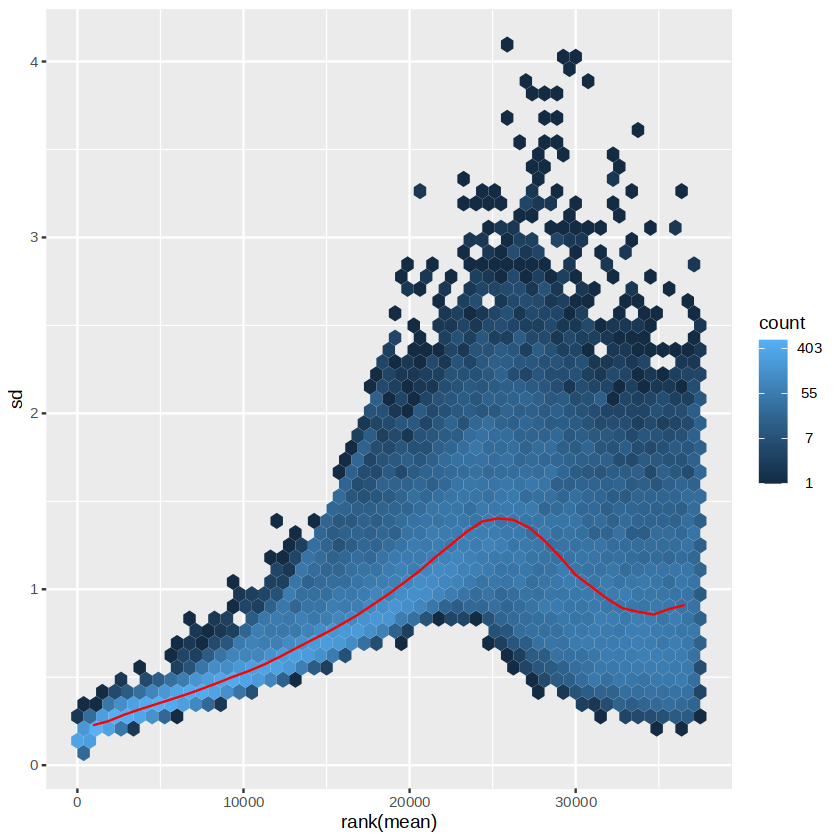

In [ ]:
# Quality assessment and diagnostic plots
perform_quality_assessment <- function(dds_object, vsd_object) {
    cat("Performing quality assessment and diagnostic plots...\n")
    
    # Mean-variance relationship plot
    cat("Creating mean-variance relationship plot...\n")
    ntd <- normTransform(dds_object)  # log2(n + 1)
    
    # Plot mean-variance relationship
    meanSdPlot(assay(ntd))
    
    # Top expressed genes heatmap - normalized data
    cat("Creating heatmap for top expressed genes (normalized data)...\n")
    select_genes <- order(rowMeans(counts(dds_object, normalized = TRUE)), 
                         decreasing = TRUE)[1:TOP_GENES_HEATMAP]
    
    annotation_df <- as.data.frame(colData(dds_object)[, c("genotype", "sample", "repl")])
    
    # Heatmap with normalized transformed data
    pheatmap(assay(ntd)[select_genes, ], 
             cluster_rows = FALSE, 
             show_rownames = FALSE,
             cluster_cols = TRUE, 
             annotation_col = annotation_df,
             main = "Top Expressed Genes - Normalized Transform",
             filename = file.path(FIGURES_DIR, "top_genes_heatmap_norm.pdf"),
             width = 10, height = 8)
    
    # Heatmap with VST data
    cat("Creating heatmap for top expressed genes (VST data)...\n")
    pheatmap(assay(vsd_object)[select_genes, ], 
             cluster_rows = FALSE, 
             show_rownames = FALSE,
             cluster_cols = TRUE, 
             annotation_col = annotation_df,
             main = "Top Expressed Genes - VST",
             filename = file.path(FIGURES_DIR, "top_genes_heatmap_vst.pdf"),
             width = 10, height = 8)
    
    cat("Quality assessment plots created and saved\n")
    
    return(list(
        selected_genes = select_genes,
        annotation = annotation_df
    ))
}

# Perform quality assessment
quality_results <- perform_quality_assessment(dds, vsd)

cat("\nQuality assessment completed!\n")

## Sample Distance Analysis

In [ ]:
# Comprehensive sample distance analysis
perform_sample_distance_analysis <- function(vsd_object) {
    cat("Performing sample distance analysis...\n")
    
    # Calculate sample distances
    cat("Calculating sample-to-sample distances...\n")
    sampleDists <- dist(t(assay(vsd_object)))
    sampleDistMatrix <- as.matrix(sampleDists)
    
    # Create informative row and column names
    sample_labels <- paste(vsd_object$genotype, vsd_object$sample, vsd_object$repl, sep = "-")
    rownames(sampleDistMatrix) <- sample_labels
    colnames(sampleDistMatrix) <- NULL
    
    # Display distance statistics
    cat("Distance matrix statistics:\n")
    cat("  Min distance:", round(min(sampleDistMatrix[sampleDistMatrix > 0]), 2), "\n")
    cat("  Max distance:", round(max(sampleDistMatrix), 2), "\n")
    cat("  Mean distance:", round(mean(sampleDistMatrix[sampleDistMatrix > 0]), 2), "\n")
    
    # Create distance heatmap
    cat("Creating sample distance heatmap...\n")
    colors <- colorRampPalette(rev(brewer.pal(9, "Blues")))(255)
    
    # Set appropriate plot size for readability
    options(repr.plot.width = 12, repr.plot.height = 10)
    
    # Create and display heatmap
    distance_heatmap <- pheatmap(sampleDistMatrix,
                                clustering_distance_rows = sampleDists,
                                clustering_distance_cols = sampleDists,
                                col = colors,
                                main = "Sample-to-Sample Distance Matrix",
                                filename = file.path(FIGURES_DIR, "sample_distance_heatmap.pdf"),
                                width = 12, height = 10)
    
    # Save distance matrix
    cat("Saving distance matrix...\n")
    distance_df <- as.data.frame(sampleDistMatrix)
    write.table(distance_df, DISTANCES_FILE, sep = "\t", quote = FALSE)
    cat("Distance matrix saved to:", DISTANCES_FILE, "\n")
    
    # Reset plot options
    options(repr.plot.width = 8, repr.plot.height = 8)
    
    cat("Sample distance analysis completed\n")
    
    return(list(
        distances = sampleDists,
        distance_matrix = sampleDistMatrix,
        heatmap = distance_heatmap
    ))
}

# Perform sample distance analysis
distance_results <- perform_sample_distance_analysis(vsd)

cat("\nSample distance analysis completed successfully!\n")

## Sample-Specific Marker Gene Analysis

In [ ]:
sampleInfo <- deseq2.colData
sampleNames <- levels(sampleInfo$sample)
markerGenesList <- list()

# Comprehensive sample-specific marker gene analysis
perform_sample_marker_analysis <- function(expression_data, metadata) {
    cat("Performing sample-specific marker gene analysis...\n")
    
    # Get unique sample names
    sample_names <- levels(metadata$sample)
    cat("Analyzing", length(sample_names), "samples:", paste(sample_names, collapse = ", "), "\n")
    
    # Initialize results storage
    marker_genes_list <- list()
    
    # Process each sample vs others
    for (sample in sample_names) {
        cat("\nAnalyzing sample:", sample, "\n")
        
        # Create binary condition (sample vs all others)
        sample_condition <- ifelse(metadata$sample == sample, sample, "others")
        sample_condition <- relevel(factor(sample_condition), ref = "others")
        
        # Update metadata with condition
        temp_metadata <- metadata
        temp_metadata$condition <- sample_condition
        
        # Create DESeq2 object for this comparison
        dds_sample <- DESeqDataSetFromMatrix(
            countData = expression_data, 
            colData = temp_metadata,
            design = ~ genotype + condition  # Control for genotype effects
        )
        
        # Filter low-count genes
        keep <- rowSums(counts(dds_sample)) >= MIN_GENE_COUNT
        dds_sample <- dds_sample[keep, ]
        
        cat("  Genes included:", nrow(dds_sample), "\n")
        
        # Run DESeq2
        dds_sample <- DESeq(dds_sample)
        
        # Get results for sample vs others
        res_sample <- results(dds_sample, contrast = c("condition", sample, "others"),
                             alpha = P_VALUE_CUTOFF)
        
        # Store results
        marker_genes_list[[sample]] <- res_sample
        
        # Summary statistics
        n_sig <- sum(res_sample$padj < P_VALUE_CUTOFF & 
                    abs(res_sample$log2FoldChange) > LFC_THRESHOLD, na.rm = TRUE)
        n_up <- sum(res_sample$padj < P_VALUE_CUTOFF & 
                   res_sample$log2FoldChange > LFC_THRESHOLD, na.rm = TRUE)
        n_down <- sum(res_sample$padj < P_VALUE_CUTOFF & 
                     res_sample$log2FoldChange < -LFC_THRESHOLD, na.rm = TRUE)
        
        cat("  Significant genes (|LFC| >", LFC_THRESHOLD, ", padj <", P_VALUE_CUTOFF, "):", n_sig, "\n")
        cat("  Upregulated:", n_up, "Downregulated:", n_down, "\n")
        
        # Save results
        results_file <- file.path(OUTPUT_DIR, paste0(sample, "_marker_genes.tsv"))
        write.table(as.data.frame(res_sample), results_file, sep = "\t", quote = FALSE)
        cat("  Results saved to:", results_file, "\n")
    }
    
    cat("\nSample-specific marker gene analysis completed!\n")
    return(marker_genes_list)
}

# Perform sample-specific marker analysis
marker_genes_list <- perform_sample_marker_analysis(filtered_data, deseq2.colData)

cat("\nMarker gene analysis completed successfully!\n")


[1] "1"


estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 142 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing



[1] "2"


estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 144 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing



[1] "3"


estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 150 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing



[1] "4"


estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 153 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing



[1] "5"


estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 155 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing



[1] "6"


estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 142 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing



[1] "7"


estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 157 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing



[1] "8"


estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 185 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing



[1] "9"


estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 145 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing



[1] "10"


estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 164 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing



[1] "11"


estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 165 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing



[1] "12"


estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 165 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing



In [ ]:
# Generate volcano plots for sample-specific marker genes
generate_marker_volcano_plots <- function(marker_results_list) {
    cat("Generating volcano plots for sample-specific marker genes...\n")
    
    # Set plot dimensions
    options(repr.plot.width = 10, repr.plot.height = 8)
    
    # Generate plots for each sample
    for (sample_name in names(marker_results_list)) {
        cat("Creating volcano plot for sample:", sample_name, "\n")
        
        res <- marker_results_list[[sample_name]]
        
        # Create volcano plot
        volcano_plot <- EnhancedVolcano(
            res,
            lab = rownames(res),
            x = 'log2FoldChange',
            y = 'pvalue',
            pCutoff = P_VALUE_CUTOFF,
            FCcutoff = LFC_THRESHOLD,
            title = paste0('Sample ', sample_name, ' vs Others'),
            subtitle = 'Marker Gene Analysis',
            caption = paste0('Log2FC cutoff: ', LFC_THRESHOLD, 
                           '; p-value cutoff: ', P_VALUE_CUTOFF),
            xlim = c(-5, 5),
            ylim = c(0, max(-log10(res$pvalue), na.rm = TRUE)),
            labSize = 3,
            pointSize = 1.5,
            colAlpha = 0.7
        )
        
        # Display plot
        print(volcano_plot)
        
        # Save plot
        plot_file <- file.path(FIGURES_DIR, paste0("volcano_", sample_name, "_markers.pdf"))
        ggsave(plot_file, plot = volcano_plot, width = 10, height = 8, units = "in")
        cat("  Plot saved to:", plot_file, "\n")
    }
    
    # Reset plot dimensions
    options(repr.plot.width = 8, repr.plot.height = 8)
    
    cat("Volcano plots generated successfully!\n")
}

# Generate volcano plots
generate_marker_volcano_plots(marker_genes_list)

cat("\nVolcano plot generation completed!\n")

## Analysis Summary and Session Information

In [ ]:
# Generate comprehensive analysis summary
generate_analysis_summary <- function() {
    cat("=== BULK RNA-SEQ ANALYSIS WITH SINGLE-CELL INTEGRATION - SUMMARY ===\n\n")
    
    cat("ANALYSIS PARAMETERS:\n")
    cat("- Minimum library size threshold:", MIN_COUNT_THRESHOLD, "\n")
    cat("- Minimum gene count threshold:", MIN_GENE_COUNT, "\n")
    cat("- P-value cutoff:", P_VALUE_CUTOFF, "\n")
    cat("- Log fold change threshold:", LFC_THRESHOLD, "\n")
    cat("- Top genes for heatmap:", TOP_GENES_HEATMAP, "\n\n")
    
    cat("DATA PROCESSING:\n")
    cat("- Original data dimensions:", nrow(data), "genes x", ncol(data), "samples\n")
    cat("- Filtered data dimensions:", nrow(filtered_data), "genes x", ncol(filtered_data), "samples\n")
    cat("- DESeq2 final dimensions:", nrow(dds), "genes x", ncol(dds), "samples\n\n")
    
    cat("SAMPLE INFORMATION:\n")
    sample_summary <- table(filtered_meta$sample)
    genotype_summary <- table(filtered_meta$genotype)
    replicate_summary <- table(filtered_meta$repl)
    
    cat("- Samples per group:", paste(names(sample_summary), "=", sample_summary, collapse = ", "), "\n")
    cat("- Genotype distribution:", paste(names(genotype_summary), "=", genotype_summary, collapse = ", "), "\n")
    cat("- Replicate distribution:", paste(names(replicate_summary), "=", replicate_summary, collapse = ", "), "\n\n")
    
    cat("ANALYSIS RESULTS:\n")
    cat("- Sample-specific marker analyses:", length(marker_genes_list), "\n")
    for (sample_name in names(marker_genes_list)) {
        res <- marker_genes_list[[sample_name]]
        n_sig <- sum(res$padj < P_VALUE_CUTOFF & abs(res$log2FoldChange) > LFC_THRESHOLD, na.rm = TRUE)
        cat("  Sample", sample_name, "markers:", n_sig, "significant genes\n")
    }
    
    cat("\nOUTPUT FILES GENERATED:\n")
    cat("- VST normalized data:", VSD_ORIG_FILE, "\n")
    cat("- Batch-corrected VST data:", VSD_CORR_FILE, "\n")
    cat("- Sample distance matrix:", DISTANCES_FILE, "\n")
    cat("- PCA plots saved to:", FIGURES_DIR, "\n")
    cat("- Heatmaps saved to:", FIGURES_DIR, "\n")
    cat("- Volcano plots saved to:", FIGURES_DIR, "\n")
    cat("- Marker gene results saved to:", OUTPUT_DIR, "\n\n")
    
    cat("REPRODUCIBILITY INFORMATION:\n")
    cat("- Analysis completed on:", Sys.time(), "\n")
    cat("- R version:", R.version.string, "\n")
    cat("- Random seed set to:", 42, "\n\n")
    
    cat("=== ANALYSIS COMPLETED SUCCESSFULLY ===\n")
}

# Generate summary
generate_analysis_summary()

# Session information for reproducibility
cat("\nSESSION INFORMATION:\n")
cat("===================\n")
sessionInfo()